```
Licensed to the Apache Software Foundation (ASF) under one
or more contributor license agreements.  See the NOTICE file
distributed with this work for additional information
regarding copyright ownership.  The ASF licenses this file
to you under the Apache License, Version 2.0 (the
"License"); you may not use this file except in compliance
with the License.  You may obtain a copy of the License at
  http://www.apache.org/licenses/LICENSE-2.0
Unless required by applicable law or agreed to in writing,
software distributed under the License is distributed on an
"AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY
KIND, either express or implied.  See the License for the
specific language governing permissions and limitations
under the License.
```

In [1]:
from pyspark.sql import SparkSession
from pyspark import StorageLevel
import geopandas as gpd
import pandas as pd
from pyspark.sql.types import StructType
from pyspark.sql.types import StructField
from pyspark.sql.types import StringType
from pyspark.sql.types import LongType
from shapely.geometry import Point
from shapely.geometry import Polygon

from sedona.register import SedonaRegistrator
from sedona.core.SpatialRDD import SpatialRDD
from sedona.core.SpatialRDD import PointRDD
from sedona.core.SpatialRDD import PolygonRDD
from sedona.core.SpatialRDD import LineStringRDD
from sedona.core.enums import FileDataSplitter
from sedona.utils.adapter import Adapter
from sedona.core.spatialOperator import KNNQuery
from sedona.core.spatialOperator import JoinQuery
from sedona.core.spatialOperator import JoinQueryRaw
from sedona.core.spatialOperator import RangeQuery
from sedona.core.spatialOperator import RangeQueryRaw
from sedona.core.formatMapper.shapefileParser import ShapefileReader
from sedona.core.formatMapper import WkbReader
from sedona.core.formatMapper import WktReader
from sedona.core.formatMapper import GeoJsonReader
from sedona.sql.types import GeometryType
from sedona.core.enums import GridType
from sedona.core.SpatialRDD import RectangleRDD
from sedona.core.enums import IndexType
from sedona.core.geom.envelope import Envelope
from sedona.utils import SedonaKryoRegistrator, KryoSerializer

In [2]:
spark = SparkSession.\
    builder.\
    master("spark://spark-master:7077").\
    appName("Sedona App").\
    config("spark.serializer", KryoSerializer.getName).\
    config("spark.kryo.registrator", SedonaKryoRegistrator.getName) .\
    getOrCreate()

/usr/local/lib/python3.9/dist-packages/pyspark/bin/load-spark-env.sh: line 68: ps: command not found
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/05/26 12:19:35 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
# Register function is essential for Apache Sedona Core and Apache Sedona SQL. 

In [4]:
SedonaRegistrator.registerAll(spark)

True

In [5]:
sc = spark.sparkContext

# Create SpatialRDD

## Reading to PointRDD from CSV file

Suppose we want load the CSV file into Apache Sedona PointRDD
```
testattribute0,-88.331492,32.324142,testattribute1,testattribute2
testattribute0,-88.175933,32.360763,testattribute1,testattribute2
testattribute0,-88.388954,32.357073,testattribute1,testattribute2
testattribute0,-88.221102,32.35078,testattribute1,testattribute2
testattribute0,-88.323995,32.950671,testattribute1,testattribute2
testattribute0,-88.231077,32.700812,testattribute1,testattribute2
```

In [7]:
point_rdd = PointRDD(sc, "../data/arealm-small.csv", 1, FileDataSplitter.CSV, True, 10, StorageLevel.MEMORY_ONLY, "epsg:4326", "epsg:4326")

In [8]:
## Getting approximate total count
point_rdd.approximateTotalCount

3000

/usr/local/lib/python3.9/dist-packages/sedona/core/geom/envelope.py:27: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  self.minx = minx
/usr/local/lib/python3.9/dist-packages/sedona/core/geom/envelope.py:28: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  self.maxx = maxx
/usr/local/lib/python3.9/dist-packages/sedona/core/geom/envelope.py:29: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  self.miny = miny
/usr/local/lib/python3.9/dist-packages/sedona/core/geom/envelope.py:30: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  self.maxy = maxy


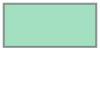

In [9]:
# getting boundary for PointRDD or any other SpatialRDD, it returns Enelope object which inherits from
# shapely.geometry.Polygon
point_rdd.boundary()

In [10]:
# To run analyze please use function analyze
point_rdd.analyze()

True

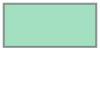

In [11]:
# Finding boundary envelope for PointRDD or any other SpatialRDD, it returns Enelope object which inherits from
# shapely.geometry.Polygon
point_rdd.boundaryEnvelope

In [12]:
# Calculate number of records without duplicates
point_rdd.countWithoutDuplicates()

2996

In [13]:
# Getting source epsg code
point_rdd.getSourceEpsgCode()

'epsg:4326'

In [14]:
# Getting target epsg code
point_rdd.getTargetEpsgCode()

'epsg:4326'

In [15]:
# Spatial partitioning data
point_rdd.spatialPartitioning(GridType.KDBTREE)

True

## Operations on RawSpatialRDD

rawSpatialRDD method returns RDD which consists of GeoData objects which has 2 attributes
<li> geom: shapely.geometry.BaseGeometry </li>
<li> userData: str </li>

You can use any operations on those objects and spread across machines

In [16]:
# take firs element
point_rdd.rawSpatialRDD.take(1)

23/05/26 12:20:37 WARN TaskSetManager: Lost task 0.0 in stage 8.0 (TID 52) (172.25.0.5 executor 1): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/usr/bin/spark-3.3.2-bin-hadoop3/python/lib/pyspark.zip/pyspark/worker.py", line 668, in main
    func, profiler, deserializer, serializer = read_command(pickleSer, infile)
  File "/usr/bin/spark-3.3.2-bin-hadoop3/python/lib/pyspark.zip/pyspark/worker.py", line 85, in read_command
    command = serializer._read_with_length(file)
  File "/usr/bin/spark-3.3.2-bin-hadoop3/python/lib/pyspark.zip/pyspark/serializers.py", line 173, in _read_with_length
    return self.loads(obj)
  File "/usr/bin/spark-3.3.2-bin-hadoop3/python/lib/pyspark.zip/pyspark/serializers.py", line 471, in loads
    return cloudpickle.loads(obj, encoding=encoding)
ModuleNotFoundError: No module named 'sedona'

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:552)
	at org.apache.s

23/05/26 12:20:37 ERROR TaskSetManager: Task 0 in stage 8.0 failed 4 times; aborting job


Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.runJob.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 8.0 failed 4 times, most recent failure: Lost task 0.3 in stage 8.0 (TID 55) (172.25.0.5 executor 1): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/usr/bin/spark-3.3.2-bin-hadoop3/python/lib/pyspark.zip/pyspark/worker.py", line 668, in main
    func, profiler, deserializer, serializer = read_command(pickleSer, infile)
  File "/usr/bin/spark-3.3.2-bin-hadoop3/python/lib/pyspark.zip/pyspark/worker.py", line 85, in read_command
    command = serializer._read_with_length(file)
  File "/usr/bin/spark-3.3.2-bin-hadoop3/python/lib/pyspark.zip/pyspark/serializers.py", line 173, in _read_with_length
    return self.loads(obj)
  File "/usr/bin/spark-3.3.2-bin-hadoop3/python/lib/pyspark.zip/pyspark/serializers.py", line 471, in loads
    return cloudpickle.loads(obj, encoding=encoding)
ModuleNotFoundError: No module named 'sedona'

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:552)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:758)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:740)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:505)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at scala.collection.generic.Growable.$plus$plus$eq(Growable.scala:62)
	at scala.collection.generic.Growable.$plus$plus$eq$(Growable.scala:53)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:105)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:49)
	at scala.collection.TraversableOnce.to(TraversableOnce.scala:366)
	at scala.collection.TraversableOnce.to$(TraversableOnce.scala:364)
	at org.apache.spark.InterruptibleIterator.to(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toBuffer(TraversableOnce.scala:358)
	at scala.collection.TraversableOnce.toBuffer$(TraversableOnce.scala:358)
	at org.apache.spark.InterruptibleIterator.toBuffer(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toArray(TraversableOnce.scala:345)
	at scala.collection.TraversableOnce.toArray$(TraversableOnce.scala:339)
	at org.apache.spark.InterruptibleIterator.toArray(InterruptibleIterator.scala:28)
	at org.apache.spark.api.python.PythonRDD$.$anonfun$runJob$1(PythonRDD.scala:166)
	at org.apache.spark.SparkContext.$anonfun$runJob$5(SparkContext.scala:2278)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:136)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:548)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1504)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:551)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:750)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2672)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2608)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2607)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2607)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1182)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1182)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1182)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2860)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2802)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2791)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:952)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2238)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2259)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2278)
	at org.apache.spark.api.python.PythonRDD$.runJob(PythonRDD.scala:166)
	at org.apache.spark.api.python.PythonRDD.runJob(PythonRDD.scala)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.lang.Thread.run(Thread.java:750)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/usr/bin/spark-3.3.2-bin-hadoop3/python/lib/pyspark.zip/pyspark/worker.py", line 668, in main
    func, profiler, deserializer, serializer = read_command(pickleSer, infile)
  File "/usr/bin/spark-3.3.2-bin-hadoop3/python/lib/pyspark.zip/pyspark/worker.py", line 85, in read_command
    command = serializer._read_with_length(file)
  File "/usr/bin/spark-3.3.2-bin-hadoop3/python/lib/pyspark.zip/pyspark/serializers.py", line 173, in _read_with_length
    return self.loads(obj)
  File "/usr/bin/spark-3.3.2-bin-hadoop3/python/lib/pyspark.zip/pyspark/serializers.py", line 471, in loads
    return cloudpickle.loads(obj, encoding=encoding)
ModuleNotFoundError: No module named 'sedona'

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:552)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:758)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:740)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:505)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at scala.collection.generic.Growable.$plus$plus$eq(Growable.scala:62)
	at scala.collection.generic.Growable.$plus$plus$eq$(Growable.scala:53)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:105)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:49)
	at scala.collection.TraversableOnce.to(TraversableOnce.scala:366)
	at scala.collection.TraversableOnce.to$(TraversableOnce.scala:364)
	at org.apache.spark.InterruptibleIterator.to(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toBuffer(TraversableOnce.scala:358)
	at scala.collection.TraversableOnce.toBuffer$(TraversableOnce.scala:358)
	at org.apache.spark.InterruptibleIterator.toBuffer(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toArray(TraversableOnce.scala:345)
	at scala.collection.TraversableOnce.toArray$(TraversableOnce.scala:339)
	at org.apache.spark.InterruptibleIterator.toArray(InterruptibleIterator.scala:28)
	at org.apache.spark.api.python.PythonRDD$.$anonfun$runJob$1(PythonRDD.scala:166)
	at org.apache.spark.SparkContext.$anonfun$runJob$5(SparkContext.scala:2278)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:136)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:548)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1504)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:551)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more


In [17]:
# collect to Python list
point_rdd.rawSpatialRDD.collect()[:5]

[Geometry: Point userData: testattribute0	testattribute1	testattribute2,
 Geometry: Point userData: testattribute0	testattribute1	testattribute2,
 Geometry: Point userData: testattribute0	testattribute1	testattribute2,
 Geometry: Point userData: testattribute0	testattribute1	testattribute2,
 Geometry: Point userData: testattribute0	testattribute1	testattribute2]

In [18]:
# apply map functions, for example distance to Point(52 21)
point_rdd.rawSpatialRDD.map(lambda x: x.geom.distance(Point(21, 52))).take(5)

23/05/26 12:21:17 WARN TaskSetManager: Lost task 0.0 in stage 10.0 (TID 66) (172.25.0.5 executor 1): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/usr/bin/spark-3.3.2-bin-hadoop3/python/lib/pyspark.zip/pyspark/worker.py", line 668, in main
    func, profiler, deserializer, serializer = read_command(pickleSer, infile)
  File "/usr/bin/spark-3.3.2-bin-hadoop3/python/lib/pyspark.zip/pyspark/worker.py", line 85, in read_command
    command = serializer._read_with_length(file)
  File "/usr/bin/spark-3.3.2-bin-hadoop3/python/lib/pyspark.zip/pyspark/serializers.py", line 173, in _read_with_length
    return self.loads(obj)
  File "/usr/bin/spark-3.3.2-bin-hadoop3/python/lib/pyspark.zip/pyspark/serializers.py", line 471, in loads
    return cloudpickle.loads(obj, encoding=encoding)
ModuleNotFoundError: No module named 'shapely'

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:552)
	at org.apache

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.runJob.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 10.0 failed 4 times, most recent failure: Lost task 0.3 in stage 10.0 (TID 69) (172.25.0.5 executor 1): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/usr/bin/spark-3.3.2-bin-hadoop3/python/lib/pyspark.zip/pyspark/worker.py", line 668, in main
    func, profiler, deserializer, serializer = read_command(pickleSer, infile)
  File "/usr/bin/spark-3.3.2-bin-hadoop3/python/lib/pyspark.zip/pyspark/worker.py", line 85, in read_command
    command = serializer._read_with_length(file)
  File "/usr/bin/spark-3.3.2-bin-hadoop3/python/lib/pyspark.zip/pyspark/serializers.py", line 173, in _read_with_length
    return self.loads(obj)
  File "/usr/bin/spark-3.3.2-bin-hadoop3/python/lib/pyspark.zip/pyspark/serializers.py", line 471, in loads
    return cloudpickle.loads(obj, encoding=encoding)
ModuleNotFoundError: No module named 'shapely'

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:552)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:758)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:740)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:505)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at scala.collection.generic.Growable.$plus$plus$eq(Growable.scala:62)
	at scala.collection.generic.Growable.$plus$plus$eq$(Growable.scala:53)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:105)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:49)
	at scala.collection.TraversableOnce.to(TraversableOnce.scala:366)
	at scala.collection.TraversableOnce.to$(TraversableOnce.scala:364)
	at org.apache.spark.InterruptibleIterator.to(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toBuffer(TraversableOnce.scala:358)
	at scala.collection.TraversableOnce.toBuffer$(TraversableOnce.scala:358)
	at org.apache.spark.InterruptibleIterator.toBuffer(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toArray(TraversableOnce.scala:345)
	at scala.collection.TraversableOnce.toArray$(TraversableOnce.scala:339)
	at org.apache.spark.InterruptibleIterator.toArray(InterruptibleIterator.scala:28)
	at org.apache.spark.api.python.PythonRDD$.$anonfun$runJob$1(PythonRDD.scala:166)
	at org.apache.spark.SparkContext.$anonfun$runJob$5(SparkContext.scala:2278)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:136)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:548)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1504)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:551)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:750)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2672)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2608)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2607)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2607)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1182)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1182)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1182)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2860)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2802)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2791)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:952)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2238)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2259)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2278)
	at org.apache.spark.api.python.PythonRDD$.runJob(PythonRDD.scala:166)
	at org.apache.spark.api.python.PythonRDD.runJob(PythonRDD.scala)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.lang.Thread.run(Thread.java:750)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/usr/bin/spark-3.3.2-bin-hadoop3/python/lib/pyspark.zip/pyspark/worker.py", line 668, in main
    func, profiler, deserializer, serializer = read_command(pickleSer, infile)
  File "/usr/bin/spark-3.3.2-bin-hadoop3/python/lib/pyspark.zip/pyspark/worker.py", line 85, in read_command
    command = serializer._read_with_length(file)
  File "/usr/bin/spark-3.3.2-bin-hadoop3/python/lib/pyspark.zip/pyspark/serializers.py", line 173, in _read_with_length
    return self.loads(obj)
  File "/usr/bin/spark-3.3.2-bin-hadoop3/python/lib/pyspark.zip/pyspark/serializers.py", line 471, in loads
    return cloudpickle.loads(obj, encoding=encoding)
ModuleNotFoundError: No module named 'shapely'

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:552)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:758)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:740)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:505)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at scala.collection.generic.Growable.$plus$plus$eq(Growable.scala:62)
	at scala.collection.generic.Growable.$plus$plus$eq$(Growable.scala:53)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:105)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:49)
	at scala.collection.TraversableOnce.to(TraversableOnce.scala:366)
	at scala.collection.TraversableOnce.to$(TraversableOnce.scala:364)
	at org.apache.spark.InterruptibleIterator.to(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toBuffer(TraversableOnce.scala:358)
	at scala.collection.TraversableOnce.toBuffer$(TraversableOnce.scala:358)
	at org.apache.spark.InterruptibleIterator.toBuffer(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toArray(TraversableOnce.scala:345)
	at scala.collection.TraversableOnce.toArray$(TraversableOnce.scala:339)
	at org.apache.spark.InterruptibleIterator.toArray(InterruptibleIterator.scala:28)
	at org.apache.spark.api.python.PythonRDD$.$anonfun$runJob$1(PythonRDD.scala:166)
	at org.apache.spark.SparkContext.$anonfun$runJob$5(SparkContext.scala:2278)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:136)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:548)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1504)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:551)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more


## Transforming to GeoPandas

## Loaded data can be transfomred to GeoPandas DataFrame few ways

### Directly from RDD

In [19]:
point_rdd_to_geo = point_rdd.rawSpatialRDD.map(lambda x: [x.geom, *x.getUserData().split("\t")])

In [20]:
point_gdf = gpd.GeoDataFrame(
    point_rdd_to_geo.collect(), columns=["geom", "attr1", "attr2", "attr3"], geometry="geom"
)

23/05/26 12:22:06 WARN TaskSetManager: Lost task 0.0 in stage 11.0 (TID 71) (172.25.0.5 executor 1): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/usr/bin/spark-3.3.2-bin-hadoop3/python/lib/pyspark.zip/pyspark/worker.py", line 668, in main
    func, profiler, deserializer, serializer = read_command(pickleSer, infile)
  File "/usr/bin/spark-3.3.2-bin-hadoop3/python/lib/pyspark.zip/pyspark/worker.py", line 85, in read_command
    command = serializer._read_with_length(file)
  File "/usr/bin/spark-3.3.2-bin-hadoop3/python/lib/pyspark.zip/pyspark/serializers.py", line 173, in _read_with_length
    return self.loads(obj)
  File "/usr/bin/spark-3.3.2-bin-hadoop3/python/lib/pyspark.zip/pyspark/serializers.py", line 471, in loads
    return cloudpickle.loads(obj, encoding=encoding)
ModuleNotFoundError: No module named 'sedona'

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:552)
	at org.apache.

23/05/26 12:22:06 ERROR TaskSetManager: Task 0 in stage 11.0 failed 4 times; aborting job
23/05/26 12:22:06 WARN TaskSetManager: Lost task 2.3 in stage 11.0 (TID 78) (172.25.0.5 executor 1): TaskKilled (Stage cancelled)
23/05/26 12:22:07 WARN TaskSetManager: Lost task 1.0 in stage 11.0 (TID 70) (172.25.0.3 executor 0): TaskKilled (Stage cancelled)


Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.collectAndServe.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 11.0 failed 4 times, most recent failure: Lost task 0.3 in stage 11.0 (TID 77) (172.25.0.5 executor 1): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/usr/bin/spark-3.3.2-bin-hadoop3/python/lib/pyspark.zip/pyspark/worker.py", line 668, in main
    func, profiler, deserializer, serializer = read_command(pickleSer, infile)
  File "/usr/bin/spark-3.3.2-bin-hadoop3/python/lib/pyspark.zip/pyspark/worker.py", line 85, in read_command
    command = serializer._read_with_length(file)
  File "/usr/bin/spark-3.3.2-bin-hadoop3/python/lib/pyspark.zip/pyspark/serializers.py", line 173, in _read_with_length
    return self.loads(obj)
  File "/usr/bin/spark-3.3.2-bin-hadoop3/python/lib/pyspark.zip/pyspark/serializers.py", line 471, in loads
    return cloudpickle.loads(obj, encoding=encoding)
ModuleNotFoundError: No module named 'sedona'

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:552)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:758)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:740)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:505)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at scala.collection.generic.Growable.$plus$plus$eq(Growable.scala:62)
	at scala.collection.generic.Growable.$plus$plus$eq$(Growable.scala:53)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:105)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:49)
	at scala.collection.TraversableOnce.to(TraversableOnce.scala:366)
	at scala.collection.TraversableOnce.to$(TraversableOnce.scala:364)
	at org.apache.spark.InterruptibleIterator.to(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toBuffer(TraversableOnce.scala:358)
	at scala.collection.TraversableOnce.toBuffer$(TraversableOnce.scala:358)
	at org.apache.spark.InterruptibleIterator.toBuffer(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toArray(TraversableOnce.scala:345)
	at scala.collection.TraversableOnce.toArray$(TraversableOnce.scala:339)
	at org.apache.spark.InterruptibleIterator.toArray(InterruptibleIterator.scala:28)
	at org.apache.spark.rdd.RDD.$anonfun$collect$2(RDD.scala:1021)
	at org.apache.spark.SparkContext.$anonfun$runJob$5(SparkContext.scala:2278)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:136)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:548)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1504)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:551)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:750)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2672)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2608)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2607)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2607)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1182)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1182)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1182)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2860)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2802)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2791)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:952)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2238)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2259)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2278)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2303)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1021)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:406)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1020)
	at org.apache.spark.api.python.PythonRDD$.collectAndServe(PythonRDD.scala:180)
	at org.apache.spark.api.python.PythonRDD.collectAndServe(PythonRDD.scala)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.lang.Thread.run(Thread.java:750)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/usr/bin/spark-3.3.2-bin-hadoop3/python/lib/pyspark.zip/pyspark/worker.py", line 668, in main
    func, profiler, deserializer, serializer = read_command(pickleSer, infile)
  File "/usr/bin/spark-3.3.2-bin-hadoop3/python/lib/pyspark.zip/pyspark/worker.py", line 85, in read_command
    command = serializer._read_with_length(file)
  File "/usr/bin/spark-3.3.2-bin-hadoop3/python/lib/pyspark.zip/pyspark/serializers.py", line 173, in _read_with_length
    return self.loads(obj)
  File "/usr/bin/spark-3.3.2-bin-hadoop3/python/lib/pyspark.zip/pyspark/serializers.py", line 471, in loads
    return cloudpickle.loads(obj, encoding=encoding)
ModuleNotFoundError: No module named 'sedona'

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:552)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:758)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:740)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:505)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at scala.collection.generic.Growable.$plus$plus$eq(Growable.scala:62)
	at scala.collection.generic.Growable.$plus$plus$eq$(Growable.scala:53)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:105)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:49)
	at scala.collection.TraversableOnce.to(TraversableOnce.scala:366)
	at scala.collection.TraversableOnce.to$(TraversableOnce.scala:364)
	at org.apache.spark.InterruptibleIterator.to(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toBuffer(TraversableOnce.scala:358)
	at scala.collection.TraversableOnce.toBuffer$(TraversableOnce.scala:358)
	at org.apache.spark.InterruptibleIterator.toBuffer(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toArray(TraversableOnce.scala:345)
	at scala.collection.TraversableOnce.toArray$(TraversableOnce.scala:339)
	at org.apache.spark.InterruptibleIterator.toArray(InterruptibleIterator.scala:28)
	at org.apache.spark.rdd.RDD.$anonfun$collect$2(RDD.scala:1021)
	at org.apache.spark.SparkContext.$anonfun$runJob$5(SparkContext.scala:2278)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:136)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:548)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1504)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:551)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more


In [21]:
point_gdf[:5]

NameError: name 'point_gdf' is not defined

### Using Adapter

In [26]:
# Adapter allow you to convert geospatial data types introduced with sedona to other ones

In [22]:
spatial_df = Adapter.\
    toDf(point_rdd, ["attr1", "attr2", "attr3"], spark).\
    createOrReplaceTempView("spatial_df")

spatial_gdf = spark.sql("Select attr1, attr2, attr3, geometry as geom from spatial_df")

In [23]:
spatial_gdf.show(5, False)

+--------------+--------------+--------------+----------------------------+
|attr1         |attr2         |attr3         |geom                        |
+--------------+--------------+--------------+----------------------------+
|testattribute0|testattribute1|testattribute2|POINT (-88.331492 32.324142)|
|testattribute0|testattribute1|testattribute2|POINT (-88.175933 32.360763)|
|testattribute0|testattribute1|testattribute2|POINT (-88.388954 32.357073)|
|testattribute0|testattribute1|testattribute2|POINT (-88.221102 32.35078) |
|testattribute0|testattribute1|testattribute2|POINT (-88.323995 32.950671)|
+--------------+--------------+--------------+----------------------------+
only showing top 5 rows



In [24]:
gpd.GeoDataFrame(spatial_gdf.toPandas(), geometry="geom")[:5]

,attr1,attr2,attr3,geom
0,testattribute0,testattribute1,testattribute2,POINT (-88.33149 32.32414)
1,testattribute0,testattribute1,testattribute2,POINT (-88.17593 32.36076)
2,testattribute0,testattribute1,testattribute2,POINT (-88.38895 32.35707)
3,testattribute0,testattribute1,testattribute2,POINT (-88.22110 32.35078)
4,testattribute0,testattribute1,testattribute2,POINT (-88.32399 32.95067)


### With DataFrame creation

In [25]:
schema = StructType(
    [
        StructField("geometry", GeometryType(), False),
        StructField("attr1", StringType(), False),
        StructField("attr2", StringType(), False),
        StructField("attr3", StringType(), False),
    ]
)

In [26]:
geo_df = spark.createDataFrame(point_rdd_to_geo, schema, verifySchema=False)

In [27]:
gpd.GeoDataFrame(geo_df.toPandas(), geometry="geometry")[:5]

23/05/26 12:22:38 WARN TaskSetManager: Lost task 0.0 in stage 14.0 (TID 91) (172.25.0.5 executor 1): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/usr/bin/spark-3.3.2-bin-hadoop3/python/lib/pyspark.zip/pyspark/worker.py", line 668, in main
    func, profiler, deserializer, serializer = read_command(pickleSer, infile)
  File "/usr/bin/spark-3.3.2-bin-hadoop3/python/lib/pyspark.zip/pyspark/worker.py", line 85, in read_command
    command = serializer._read_with_length(file)
  File "/usr/bin/spark-3.3.2-bin-hadoop3/python/lib/pyspark.zip/pyspark/serializers.py", line 173, in _read_with_length
    return self.loads(obj)
  File "/usr/bin/spark-3.3.2-bin-hadoop3/python/lib/pyspark.zip/pyspark/serializers.py", line 471, in loads
    return cloudpickle.loads(obj, encoding=encoding)
ModuleNotFoundError: No module named 'sedona'

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:552)
	at org.apache.

Py4JJavaError: An error occurred while calling o203.collectToPython.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 1 in stage 14.0 failed 4 times, most recent failure: Lost task 1.3 in stage 14.0 (TID 97) (172.25.0.3 executor 0): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/usr/bin/spark-3.3.2-bin-hadoop3/python/lib/pyspark.zip/pyspark/worker.py", line 668, in main
    func, profiler, deserializer, serializer = read_command(pickleSer, infile)
  File "/usr/bin/spark-3.3.2-bin-hadoop3/python/lib/pyspark.zip/pyspark/worker.py", line 85, in read_command
    command = serializer._read_with_length(file)
  File "/usr/bin/spark-3.3.2-bin-hadoop3/python/lib/pyspark.zip/pyspark/serializers.py", line 173, in _read_with_length
    return self.loads(obj)
  File "/usr/bin/spark-3.3.2-bin-hadoop3/python/lib/pyspark.zip/pyspark/serializers.py", line 471, in loads
    return cloudpickle.loads(obj, encoding=encoding)
ModuleNotFoundError: No module named 'sedona'

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:552)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:758)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:740)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:505)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:491)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:760)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$getByteArrayRdd$1(SparkPlan.scala:364)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2(RDD.scala:890)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2$adapted(RDD.scala:890)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:136)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:548)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1504)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:551)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:750)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2672)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2608)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2607)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2607)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1182)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1182)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1182)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2860)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2802)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2791)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:952)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2238)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2259)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2278)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2303)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1021)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:406)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1020)
	at org.apache.spark.sql.execution.SparkPlan.executeCollect(SparkPlan.scala:424)
	at org.apache.spark.sql.Dataset.$anonfun$collectToPython$1(Dataset.scala:3688)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$2(Dataset.scala:3858)
	at org.apache.spark.sql.execution.QueryExecution$.withInternalError(QueryExecution.scala:510)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$1(Dataset.scala:3856)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$6(SQLExecution.scala:109)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:169)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:95)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:779)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:64)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:3856)
	at org.apache.spark.sql.Dataset.collectToPython(Dataset.scala:3685)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.lang.Thread.run(Thread.java:750)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/usr/bin/spark-3.3.2-bin-hadoop3/python/lib/pyspark.zip/pyspark/worker.py", line 668, in main
    func, profiler, deserializer, serializer = read_command(pickleSer, infile)
  File "/usr/bin/spark-3.3.2-bin-hadoop3/python/lib/pyspark.zip/pyspark/worker.py", line 85, in read_command
    command = serializer._read_with_length(file)
  File "/usr/bin/spark-3.3.2-bin-hadoop3/python/lib/pyspark.zip/pyspark/serializers.py", line 173, in _read_with_length
    return self.loads(obj)
  File "/usr/bin/spark-3.3.2-bin-hadoop3/python/lib/pyspark.zip/pyspark/serializers.py", line 471, in loads
    return cloudpickle.loads(obj, encoding=encoding)
ModuleNotFoundError: No module named 'sedona'

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:552)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:758)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:740)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:505)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:491)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:760)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$getByteArrayRdd$1(SparkPlan.scala:364)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2(RDD.scala:890)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2$adapted(RDD.scala:890)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:136)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:548)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1504)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:551)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more


# Load Typed SpatialRDDs

Currently The library supports 5 typed SpatialRDDs:
<li> RectangleRDD </li>
<li> PointRDD </li>
<li> PolygonRDD </li>
<li> LineStringRDD </li>
<li> CircleRDD </li>

In [33]:
rectangle_rdd = RectangleRDD(sc, "data/zcta510-small.csv", FileDataSplitter.CSV, True, 11)
point_rdd = PointRDD(sc, "data/arealm-small.csv", 1, FileDataSplitter.CSV, False, 11)
polygon_rdd = PolygonRDD(sc, "data/primaryroads-polygon.csv", FileDataSplitter.CSV, True, 11)
linestring_rdd = LineStringRDD(sc, "data/primaryroads-linestring.csv", FileDataSplitter.CSV, True, StorageLevel.MEMORY_ONLY)

In [34]:
rectangle_rdd.analyze()
point_rdd.analyze()
polygon_rdd.analyze()
linestring_rdd.analyze()

True

# Spatial Partitioning

Apache Sedona spatial partitioning method can significantly speed up the join query. Three spatial partitioning methods are available: KDB-Tree, Quad-Tree and R-Tree. Two SpatialRDD must be partitioned by the same way.

In [35]:
point_rdd.spatialPartitioning(GridType.KDBTREE)

True

# Create Index

Apache Sedona provides two types of spatial indexes, Quad-Tree and R-Tree. Once you specify an index type, Apache Sedona will build a local tree index on each of the SpatialRDD partition.

In [36]:
point_rdd.buildIndex(IndexType.RTREE, True)

# SpatialJoin

Spatial join is operation which combines data based on spatial relations like:
<li> intersects </li>
<li> touches </li>
<li> within </li>
<li> etc </li>

To Use Spatial Join in GeoPyspark library please use JoinQuery object, which has implemented below methods:
```python
SpatialJoinQuery(spatialRDD: SpatialRDD, queryRDD: SpatialRDD, useIndex: bool, considerBoundaryIntersection: bool) -> RDD

DistanceJoinQuery(spatialRDD: SpatialRDD, queryRDD: SpatialRDD, useIndex: bool, considerBoundaryIntersection: bool) -> RDD

spatialJoin(queryWindowRDD: SpatialRDD, objectRDD: SpatialRDD, joinParams: JoinParams) -> RDD

DistanceJoinQueryFlat(spatialRDD: SpatialRDD, queryRDD: SpatialRDD, useIndex: bool, considerBoundaryIntersection: bool) -> RDD

SpatialJoinQueryFlat(spatialRDD: SpatialRDD, queryRDD: SpatialRDD, useIndex: bool, considerBoundaryIntersection: bool) -> RDD

```

## Example SpatialJoinQueryFlat PointRDD with RectangleRDD 

In [37]:
# partitioning the data
point_rdd.spatialPartitioning(GridType.KDBTREE)
rectangle_rdd.spatialPartitioning(point_rdd.getPartitioner())
# building an index
point_rdd.buildIndex(IndexType.RTREE, True)
# Perform Spatial Join Query
result = JoinQuery.SpatialJoinQueryFlat(point_rdd, rectangle_rdd, False, True)

As result we will get RDD[GeoData, GeoData]
It can be used like any other Python RDD. You can use map, take, collect and other functions  

In [38]:
result

MapPartitionsRDD[68] at map at FlatPairRddConverter.scala:30

In [39]:
result.take(2)

[[Geometry: Polygon userData: , Geometry: Point userData: ],
 [Geometry: Polygon userData: , Geometry: Point userData: ]]

In [40]:
result.collect()[:3]

[[Geometry: Polygon userData: , Geometry: Point userData: ],
 [Geometry: Polygon userData: , Geometry: Point userData: ],
 [Geometry: Polygon userData: , Geometry: Point userData: ]]

In [41]:
# getting distance using SpatialObjects
result.map(lambda x: x[0].geom.distance(x[1].geom)).take(5)

[0.0, 0.0, 0.0, 0.0, 0.0]

In [42]:
# getting area of polygon data
result.map(lambda x: x[0].geom.area).take(5)

[0.05189354027999942,
 0.051572544132000575,
 0.05189354027999942,
 0.05189354027999942,
 0.020876428870001032]

In [43]:
# Base on result you can create DataFrame object, using map function and build DataFrame from RDD

In [44]:
schema = StructType(
    [
        StructField("geom_left", GeometryType(), False),
        StructField("geom_right", GeometryType(), False)
    ]
)

In [45]:
# Set verifySchema to False
spatial_join_result = result.map(lambda x: [x[0].geom, x[1].geom])
spark.createDataFrame(spatial_join_result, schema, verifySchema=False).show(5, True)

+--------------------+--------------------+
|           geom_left|          geom_right|
+--------------------+--------------------+
|POLYGON ((-87.092...|POINT (-86.94719 ...|
|POLYGON ((-87.082...|POINT (-86.865782...|
|POLYGON ((-87.092...|POINT (-86.779523...|
|POLYGON ((-87.092...|POINT (-86.865782...|
|POLYGON ((-86.816...|POINT (-86.779523...|
+--------------------+--------------------+
only showing top 5 rows



In [46]:
# Above code produces DataFrame with geometry Data type

In [47]:
spark.createDataFrame(spatial_join_result, schema, verifySchema=False).printSchema()

root
 |-- geom_left: geometry (nullable = false)
 |-- geom_right: geometry (nullable = false)



We can create DataFrame object from Spatial Pair RDD using Adapter object as follows

In [48]:
Adapter.toDf(result, ["attr1"], ["attr2"], spark).show(5, True)

+--------------------+-----+--------------------+-----+
|              geom_1|attr1|              geom_2|attr2|
+--------------------+-----+--------------------+-----+
|POLYGON ((-87.092...|     |POINT (-86.94719 ...|     |
|POLYGON ((-87.082...|     |POINT (-86.865782...|     |
|POLYGON ((-87.092...|     |POINT (-86.779523...|     |
|POLYGON ((-87.092...|     |POINT (-86.865782...|     |
|POLYGON ((-86.816...|     |POINT (-86.779523...|     |
+--------------------+-----+--------------------+-----+
only showing top 5 rows



This also produce DataFrame with geometry DataType 

In [49]:
Adapter.toDf(result, ["attr1"], ["attr2"], spark).printSchema()

root
 |-- geom_1: geometry (nullable = true)
 |-- attr1: string (nullable = true)
 |-- geom_2: geometry (nullable = true)
 |-- attr2: string (nullable = true)



We can create RDD which will be of type RDD[GeoData, List[GeoData]]
We can for example calculate number of Points within some polygon data

To do that we can use code specified below

In [50]:
point_rdd.spatialPartitioning(GridType.KDBTREE)
rectangle_rdd.spatialPartitioning(point_rdd.getPartitioner())

In [51]:
spatial_join_result_non_flat = JoinQuery.SpatialJoinQuery(point_rdd, rectangle_rdd, False, True)

In [52]:
# number of point for each polygon
number_of_points = spatial_join_result_non_flat.map(lambda x: [x[0].geom, x[1].__len__()])

In [53]:
schema = StructType([
    StructField("geometry", GeometryType(), False),
    StructField("number_of_points", LongType(), False)
])

In [54]:
spark.createDataFrame(number_of_points, schema, verifySchema=False).show()

+--------------------+----------------+
|            geometry|number_of_points|
+--------------------+----------------+
|POLYGON ((-86.749...|               4|
|POLYGON ((-87.082...|              12|
|POLYGON ((-86.697...|               1|
|POLYGON ((-87.105...|              15|
|POLYGON ((-87.114...|              15|
|POLYGON ((-87.229...|               7|
|POLYGON ((-86.860...|              12|
|POLYGON ((-86.816...|               6|
|POLYGON ((-87.092...|               5|
|POLYGON ((-87.285...|              26|
+--------------------+----------------+



# KNNQuery

Spatial KNNQuery is operation which help us find answer which k number of geometries lays closest to other geometry.

For Example:
    5 closest Shops to your home. To use Spatial KNNQuery please use object 
<b> KNNQuery </b> which has one method:
```python
SpatialKnnQuery(spatialRDD: SpatialRDD, originalQueryPoint: BaseGeometry, k: int,  useIndex: bool)-> List[GeoData]
```

In [55]:
# Finds 5 closest points from PointRDD to given Point

In [56]:
result = KNNQuery.SpatialKnnQuery(point_rdd, Point(-84.01, 34.01), 5, False)

In [57]:
result

[Geometry: Point userData: ,
 Geometry: Point userData: ,
 Geometry: Point userData: ,
 Geometry: Point userData: ,
 Geometry: Point userData: ]

As Reference geometry you can also use Polygon or LineString object

In [58]:
polygon = Polygon(
    [(-84.237756, 33.904859), (-84.237756, 34.090426),
     (-83.833011, 34.090426), (-83.833011, 33.904859),
     (-84.237756, 33.904859)
    ])
polygons_nearby = KNNQuery.SpatialKnnQuery(polygon_rdd, polygon, 5, False)

In [59]:
polygons_nearby

[Geometry: Polygon userData: ,
 Geometry: Polygon userData: ,
 Geometry: Polygon userData: ,
 Geometry: Polygon userData: ,
 Geometry: Polygon userData: ]

In [60]:
polygons_nearby[0].geom.wkt

'POLYGON ((-83.993559 34.087259, -83.993559 34.131247, -83.959903 34.131247, -83.959903 34.087259, -83.993559 34.087259))'

# RangeQuery

A spatial range query takes as input a range query window and an SpatialRDD and returns all geometries that intersect / are fully covered by the query window. 
RangeQuery has one method:

```python
SpatialRangeQuery(self, spatialRDD: SpatialRDD, rangeQueryWindow: BaseGeometry, considerBoundaryIntersection: bool, usingIndex: bool) -> RDD
```

In [61]:
query_envelope = Envelope(-85.01, -60.01, 34.01, 50.01)

result_range_query = RangeQuery.SpatialRangeQuery(linestring_rdd, query_envelope, False, False)

In [62]:
result_range_query

MapPartitionsRDD[131] at map at GeometryRddConverter.scala:30

In [63]:
result_range_query.take(6)

[Geometry: LineString userData: ,
 Geometry: LineString userData: ,
 Geometry: LineString userData: ,
 Geometry: LineString userData: ,
 Geometry: LineString userData: ,
 Geometry: LineString userData: ]

In [64]:
# Creating DataFrame from result

In [65]:
schema = StructType([StructField("geometry", GeometryType(), False)])

In [66]:
spark.createDataFrame(
    result_range_query.map(lambda x: [x.geom]),
    schema,
    verifySchema=False
).show(5, True)

+--------------------+
|            geometry|
+--------------------+
|LINESTRING (-72.1...|
|LINESTRING (-72.4...|
|LINESTRING (-72.4...|
|LINESTRING (-73.4...|
|LINESTRING (-73.6...|
+--------------------+
only showing top 5 rows



# Load From other Formats

GeoPyspark allows to load the data from other Data formats like:
<li> GeoJSON </li>
<li> Shapefile </li>
<li> WKB </li>
<li> WKT </li>

In [67]:
## ShapeFile - load to SpatialRDD

In [68]:
shape_rdd = ShapefileReader.readToGeometryRDD(sc, "data/polygon")

In [69]:
shape_rdd

In [70]:
Adapter.toDf(shape_rdd, spark).show(5, True)

+--------------------+
|            geometry|
+--------------------+
|MULTIPOLYGON (((1...|
|MULTIPOLYGON (((-...|
|MULTIPOLYGON (((1...|
|POLYGON ((118.362...|
|MULTIPOLYGON (((-...|
+--------------------+
only showing top 5 rows



In [71]:
## GeoJSON - load to SpatialRDD

```
{ "type": "Feature", "properties": { "STATEFP": "01", "COUNTYFP": "077", "TRACTCE": "011501", "BLKGRPCE": "5", "AFFGEOID": "1500000US010770115015", "GEOID": "010770115015", "NAME": "5", "LSAD": "BG", "ALAND": 6844991, "AWATER": 32636 }, "geometry": { "type": "Polygon", "coordinates": [ [ [ -87.621765, 34.873444 ], [ -87.617535, 34.873369 ], [ -87.6123, 34.873337 ], [ -87.604049, 34.873303 ], [ -87.604033, 34.872316 ], [ -87.60415, 34.867502 ], [ -87.604218, 34.865687 ], [ -87.604409, 34.858537 ], [ -87.604018, 34.851336 ], [ -87.603716, 34.844829 ], [ -87.603696, 34.844307 ], [ -87.603673, 34.841884 ], [ -87.60372, 34.841003 ], [ -87.603879, 34.838423 ], [ -87.603888, 34.837682 ], [ -87.603889, 34.83763 ], [ -87.613127, 34.833938 ], [ -87.616451, 34.832699 ], [ -87.621041, 34.831431 ], [ -87.621056, 34.831526 ], [ -87.62112, 34.831925 ], [ -87.621603, 34.8352 ], [ -87.62158, 34.836087 ], [ -87.621383, 34.84329 ], [ -87.621359, 34.844438 ], [ -87.62129, 34.846387 ], [ -87.62119, 34.85053 ], [ -87.62144, 34.865379 ], [ -87.621765, 34.873444 ] ] ] } },
```

In [72]:
geo_json_rdd = GeoJsonReader.readToGeometryRDD(sc, "data/testPolygon.json")

In [73]:
geo_json_rdd

In [74]:
Adapter.toDf(geo_json_rdd, spark).drop("AWATER").show(5, True)

+--------------------+-------+--------+-------+--------+--------------------+------------+----+----+--------+
|            geometry|STATEFP|COUNTYFP|TRACTCE|BLKGRPCE|            AFFGEOID|       GEOID|NAME|LSAD|   ALAND|
+--------------------+-------+--------+-------+--------+--------------------+------------+----+----+--------+
|POLYGON ((-87.621...|     01|     077| 011501|       5|1500000US01077011...|010770115015|   5|  BG| 6844991|
|POLYGON ((-85.719...|     01|     045| 021102|       4|1500000US01045021...|010450211024|   4|  BG|11360854|
|POLYGON ((-86.000...|     01|     055| 001300|       3|1500000US01055001...|010550013003|   3|  BG| 1378742|
|POLYGON ((-86.574...|     01|     089| 001700|       2|1500000US01089001...|010890017002|   2|  BG| 1040641|
|POLYGON ((-85.382...|     01|     069| 041400|       1|1500000US01069041...|010690414001|   1|  BG| 8243574|
+--------------------+-------+--------+-------+--------+--------------------+------------+----+----+--------+
only showi

In [75]:
## WKT - loading to SpatialRDD

In [76]:
wkt_rdd = WktReader.readToGeometryRDD(sc, "data/county_small.tsv", 0, True, False)

In [77]:
wkt_rdd

In [78]:
Adapter.toDf(wkt_rdd, spark).printSchema()

root
 |-- geometry: geometry (nullable = true)



In [79]:
Adapter.toDf(wkt_rdd, spark).show(5, True)

+--------------------+
|            geometry|
+--------------------+
|POLYGON ((-97.019...|
|POLYGON ((-123.43...|
|POLYGON ((-104.56...|
|POLYGON ((-96.910...|
|POLYGON ((-98.273...|
+--------------------+
only showing top 5 rows



In [80]:
## WKB - load to SpatialRDD

In [81]:
wkb_rdd = WkbReader.readToGeometryRDD(sc, "data/county_small_wkb.tsv", 0, True, False)

In [82]:
Adapter.toDf(wkb_rdd, spark).show(5, True)

+--------------------+
|            geometry|
+--------------------+
|POLYGON ((-97.019...|
|POLYGON ((-123.43...|
|POLYGON ((-104.56...|
|POLYGON ((-96.910...|
|POLYGON ((-98.273...|
+--------------------+
only showing top 5 rows



## Converting RDD Spatial join result to DF directly, avoiding jvm python serde

In [83]:
point_rdd.spatialPartitioning(GridType.KDBTREE)
rectangle_rdd.spatialPartitioning(point_rdd.getPartitioner())
# building an index
point_rdd.buildIndex(IndexType.RTREE, True)
# Perform Spatial Join Query
result = JoinQueryRaw.SpatialJoinQueryFlat(point_rdd, rectangle_rdd, False, True)

In [84]:
# without passing column names, the result will contain only two geometries columns
geometry_df = Adapter.toDf(result, spark)

In [85]:
geometry_df.printSchema()

root
 |-- leftgeometry: geometry (nullable = true)
 |-- rightgeometry: geometry (nullable = true)



In [86]:
geometry_df.show(5)

+--------------------+--------------------+
|        leftgeometry|       rightgeometry|
+--------------------+--------------------+
|POLYGON ((-87.229...|POINT (-87.105455...|
|POLYGON ((-87.229...|POINT (-87.10534 ...|
|POLYGON ((-87.229...|POINT (-87.160372...|
|POLYGON ((-87.229...|POINT (-87.204033...|
|POLYGON ((-87.229...|POINT (-87.204299...|
+--------------------+--------------------+
only showing top 5 rows



In [87]:
geometry_df.collect()[0]

Row(leftgeometry=<shapely.geometry.polygon.Polygon object at 0x11ffdb100>, rightgeometry=<shapely.geometry.point.Point object at 0x11ffdb1c0>)

## Passing column names

In [88]:
geometry_df = Adapter.toDf(result, ["left_user_data"], ["right_user_data"], spark)

In [89]:
geometry_df.show(5)

+--------------------+--------------+--------------------+---------------+
|        leftgeometry|left_user_data|       rightgeometry|right_user_data|
+--------------------+--------------+--------------------+---------------+
|POLYGON ((-87.229...|              |POINT (-87.105455...|           null|
|POLYGON ((-87.229...|              |POINT (-87.10534 ...|           null|
|POLYGON ((-87.229...|              |POINT (-87.160372...|           null|
|POLYGON ((-87.229...|              |POINT (-87.204033...|           null|
|POLYGON ((-87.229...|              |POINT (-87.204299...|           null|
+--------------------+--------------+--------------------+---------------+
only showing top 5 rows



# Converting RDD Spatial join result to DF directly, avoiding jvm python serde

In [90]:
query_envelope = Envelope(-85.01, -60.01, 34.01, 50.01)

result_range_query = RangeQueryRaw.SpatialRangeQuery(linestring_rdd, query_envelope, False, False)

In [91]:
# converting to df
gdf = Adapter.toDf(result_range_query, spark)

In [92]:
gdf.show(5)

+--------------------+
|            geometry|
+--------------------+
|LINESTRING (-72.1...|
|LINESTRING (-72.4...|
|LINESTRING (-72.4...|
|LINESTRING (-73.4...|
|LINESTRING (-73.6...|
+--------------------+
only showing top 5 rows



In [93]:
gdf.printSchema()

root
 |-- geometry: geometry (nullable = true)



In [94]:
# Passing column names
# converting to df
gdf_with_columns = Adapter.toDf(result_range_query, spark, ["_c1"])

In [95]:
gdf_with_columns.show(5)

+--------------------+---+
|            geometry|_c1|
+--------------------+---+
|LINESTRING (-72.1...|   |
|LINESTRING (-72.4...|   |
|LINESTRING (-72.4...|   |
|LINESTRING (-73.4...|   |
|LINESTRING (-73.6...|   |
+--------------------+---+
only showing top 5 rows



In [96]:
gdf_with_columns.printSchema()

root
 |-- geometry: geometry (nullable = true)
 |-- _c1: string (nullable = true)

